# Modelling Optimization

Purpose:
* improve the FB Prophet model performance as much as possible by:
    * Tunning Hyper Params
    * Cross Validation
    * adjusting log / indexing of monetary features
* Check against baseline results 
* Make Predictions with model

Time permitting:
* tune ARIMA model and check against prophet tuned model and baseline models.

In [7]:
# data cleaning 
import pandas as pd
import datetime as dt
from datetime import datetime
import numpy as np

# visualizations
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
# modelling - prophet
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

import itertools
# modelling - other
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
# import statsmodels.API as sm
import warnings; 
warnings.simplefilter('ignore')
#surpress scientific notation
pd.options.display.float_format = '{:,.2f}'.format

In [8]:
# import model data log
data_log = pd.read_csv('data/model_data_log.csv')

# import model data in dollars (not log)
model_data_grouped = pd.read_csv('data/model_data_grouped.csv')
model_data_grouped

ds              y
0    1988-01-01  32,094,345.55
1    1988-02-01  26,852,319.99
2    1988-03-01  34,003,540.09
3    1988-04-01  27,637,080.92
4    1988-05-01  82,665,791.27
..          ...            ...
415  2022-08-01 152,486,864.49
416  2022-09-01 124,696,349.31
417  2022-10-01 118,856,472.23
418  2022-11-01  84,952,911.97
419  2022-12-01 129,159,026.77

[420 rows x 2 columns]

In [9]:
# Function to get the variable name of a DataFrame
def get_variable_name(dataframe, namespace):
    ''' for documentation, when want to refer to the name of the dataframe, not the dataframe itself
    '''
    for name, obj in namespace.items():
        if obj is dataframe:
            return name
    return None

## Baseline Model 1: Prophet
(from other notebook)

In [10]:
def df_year_filter(df_name, start_year, end_year):
    ''' filters data based on period year for modelling
    '''
    df_name['ds'] = pd.to_datetime(df_name['ds'])
    result = df_name.loc[(df_name['ds'].dt.year >= start_year) & (df_name['ds'].dt.year <= end_year)].reset_index(drop=True)
    return result

In [11]:
# create train data set for years 1988 to 2017, will predict years 2018,2019
train_data = df_year_filter(data_log, start_year=1988, end_year=2017)
# train_data
test_data = df_year_filter(data_log, start_year=2018, end_year=2019)
# test_data

In [12]:
# initialise model, no custom params
m=Prophet()
# fit train data to model
m.fit(train_data)

15:59:34 - cmdstanpy - INFO - Chain [1] start processing
15:59:34 - cmdstanpy - INFO - Chain [1] done processing


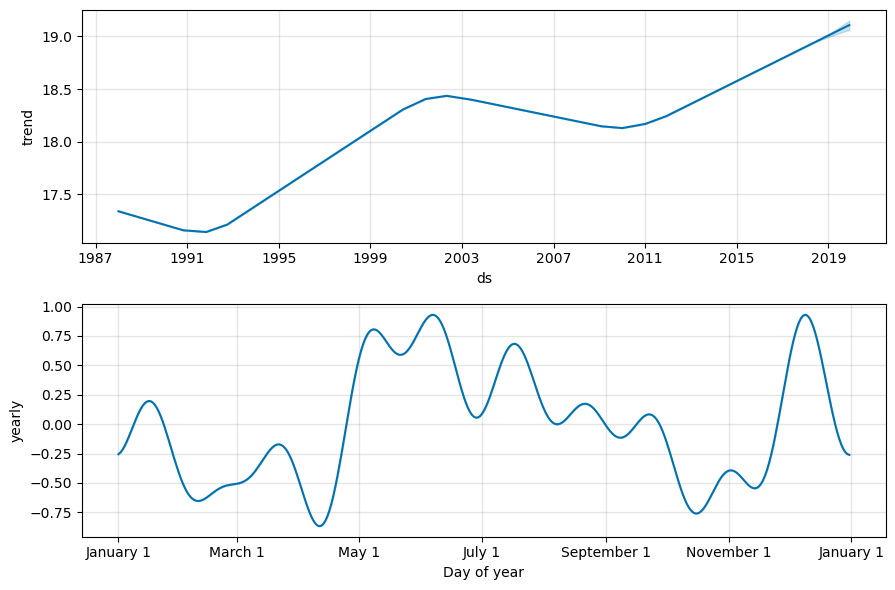

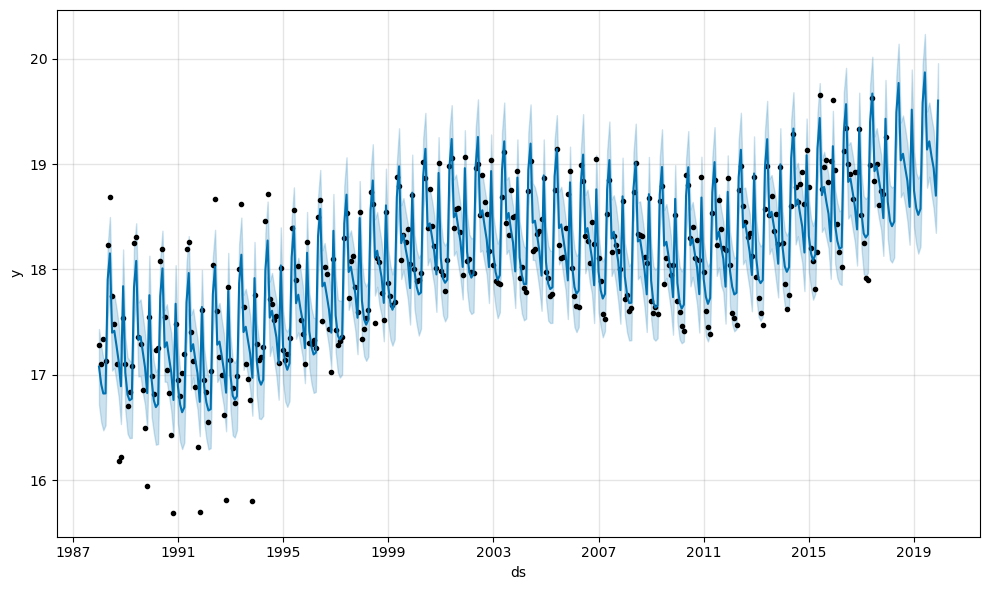

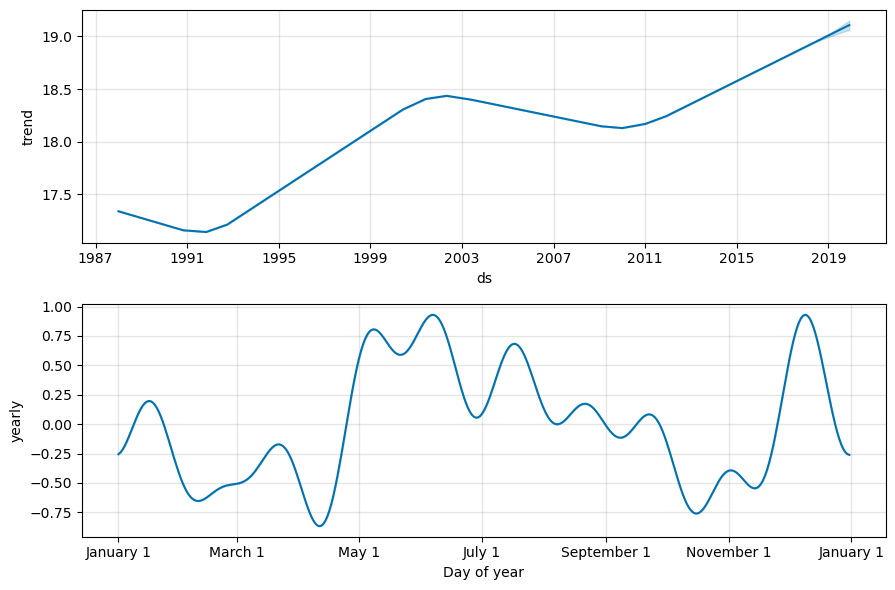

In [13]:
# predict 2018, 2019
future = m.make_future_dataframe(periods = 24, freq="MS")
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

In [14]:
forecast = m.predict(future)
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predictions

ds  yhat  yhat_lower  yhat_upper
0   1988-01-01 17.08       16.73       17.45
1   1988-02-01 16.91       16.58       17.27
2   1988-03-01 16.82       16.49       17.19
3   1988-04-01 16.82       16.46       17.20
4   1988-05-01 17.91       17.56       18.24
..         ...   ...         ...         ...
379 2019-08-01 19.22       18.85       19.57
380 2019-09-01 19.08       18.71       19.41
381 2019-10-01 18.96       18.61       19.31
382 2019-11-01 18.70       18.33       19.04
383 2019-12-01 19.60       19.26       19.96

[384 rows x 4 columns]

In [15]:
# get actual values for each period, between 1988 and 2017, values in LOG 
actuals = df_year_filter(data_log, 1988, 2019)
actuals = actuals.rename(columns={'y': 'y-actual'})
actuals

ds  y-actual
0   1988-01-01     17.28
1   1988-02-01     17.11
2   1988-03-01     17.34
3   1988-04-01     17.13
4   1988-05-01     18.23
..         ...       ...
379 2019-08-01     19.06
380 2019-09-01     18.96
381 2019-10-01     18.92
382 2019-11-01     18.72
383 2019-12-01     19.40

[384 rows x 2 columns]

In [16]:
# join actual values and predicted values into one DF
model_eval = predictions.merge(actuals, on='ds', how = 'inner')
model_eval = model_eval.rename(columns={'yhat': 'y-predicted'})
model_eval

ds  y-predicted  yhat_lower  yhat_upper  y-actual
0   1988-01-01        17.08       16.73       17.45     17.28
1   1988-02-01        16.91       16.58       17.27     17.11
2   1988-03-01        16.82       16.49       17.19     17.34
3   1988-04-01        16.82       16.46       17.20     17.13
4   1988-05-01        17.91       17.56       18.24     18.23
..         ...          ...         ...         ...       ...
379 2019-08-01        19.22       18.85       19.57     19.06
380 2019-09-01        19.08       18.71       19.41     18.96
381 2019-10-01        18.96       18.61       19.31     18.92
382 2019-11-01        18.70       18.33       19.04     18.72
383 2019-12-01        19.60       19.26       19.96     19.40

[384 rows x 5 columns]

### Evaluate Model Performance

In [17]:
# return vals to original, take exponent
model_eval_exp = model_eval.copy()
model_eval_exp

ds  y-predicted  yhat_lower  yhat_upper  y-actual
0   1988-01-01        17.08       16.73       17.45     17.28
1   1988-02-01        16.91       16.58       17.27     17.11
2   1988-03-01        16.82       16.49       17.19     17.34
3   1988-04-01        16.82       16.46       17.20     17.13
4   1988-05-01        17.91       17.56       18.24     18.23
..         ...          ...         ...         ...       ...
379 2019-08-01        19.22       18.85       19.57     19.06
380 2019-09-01        19.08       18.71       19.41     18.96
381 2019-10-01        18.96       18.61       19.31     18.92
382 2019-11-01        18.70       18.33       19.04     18.72
383 2019-12-01        19.60       19.26       19.96     19.40

[384 rows x 5 columns]

In [18]:
# return values to original non - log $
model_eval_exp[['y-predicted', 'yhat_lower', 'yhat_upper', 'y-actual']] = np.exp(model_eval_exp[['y-predicted', 'yhat_lower', 'yhat_upper', 'y-actual']])

In [19]:
model_eval_exp

ds    y-predicted     yhat_lower     yhat_upper       y-actual
0   1988-01-01  26,125,427.81  18,512,715.61  37,845,437.71  32,094,345.55
1   1988-02-01  22,072,594.23  15,816,274.31  31,763,076.12  26,852,319.99
2   1988-03-01  20,225,349.91  14,462,891.51  29,236,038.13  34,003,540.09
3   1988-04-01  20,240,672.14  14,126,007.64  29,423,769.62  27,637,080.92
4   1988-05-01  59,779,802.07  42,320,746.20  83,217,177.23  82,665,791.27
..         ...            ...            ...            ...            ...
379 2019-08-01 221,450,826.28 154,141,751.21 316,157,151.69 190,136,068.39
380 2019-09-01 192,477,647.44 133,863,795.43 267,721,858.77 172,289,856.95
381 2019-10-01 171,613,607.06 120,392,636.71 243,930,160.86 165,147,457.37
382 2019-11-01 132,153,630.87  91,639,782.75 186,082,548.80 135,296,729.64
383 2019-12-01 325,911,173.30 232,021,523.76 467,188,990.36 265,026,569.75

[384 rows x 5 columns]

In [20]:
#split results for test and train to get metrics for each. 
model_eval_exp_train = df_year_filter(model_eval_exp, 1988, 2017)
model_eval_exp_test = df_year_filter(model_eval_exp, 2018, 2019)


In [21]:
## Baseline Model Documentation:

baseline_rmse = mean_squared_error(model_eval_exp['y-predicted'],model_eval_exp['y-actual'], squared = False)
baseline_rmse_test = mean_squared_error(model_eval_exp_test['y-predicted'],model_eval_exp_test['y-actual'], squared = False)
baseline_rmse_train =  mean_squared_error(model_eval_exp_train['y-predicted'],model_eval_exp_train['y-actual'], squared = False)

baseline_mse = mean_squared_error(model_eval_exp['y-predicted'],model_eval_exp['y-actual'], squared = True)
baseline_mse_test = mean_squared_error(model_eval_exp_test['y-predicted'],model_eval_exp_test['y-actual'], squared = True)
baseline_mse_train =  mean_squared_error(model_eval_exp_train['y-predicted'],model_eval_exp_train['y-actual'], squared = True)

# print(f'baseline rmse for 1988 to 2019 {baseline_rmse} \n baseline mse for 1988 to 2019 {baseline_mse}')

mape_val = mean_absolute_percentage_error(model_eval_exp['y-predicted'],model_eval_exp['y-actual'])
mape_val_test =mean_absolute_percentage_error(model_eval_exp_test['y-predicted'],model_eval_exp_test['y-actual'])
mape_val_train = mean_absolute_percentage_error(model_eval_exp_train['y-predicted'],model_eval_exp_train['y-actual'])

# print(f'mape for 1988 to 2019 {mape_val}')
baseline_results_dict = {'RMSE':[baseline_rmse,baseline_rmse_test,baseline_rmse_train], 'MSE':[baseline_mse,baseline_mse_test,baseline_mse_train], 
'MAPE':[mape_val,mape_val_test,mape_val_train]}
baseline_results = pd.DataFrame(data=baseline_results_dict, index = ['1988 to 2019', 'test: 1988-2017', 'train:2018-2019'])
baseline_results

                                        


RMSE                      MSE  MAPE
1988 to 2019    26,113,149.25   681,896,563,522,653.88  0.20
test: 1988-2017 51,807,034.99 2,683,968,874,187,328.50  0.21
train:2018-2019 23,418,477.24   548,425,076,145,008.88  0.20

In [22]:
baseline_results_dict

{'RMSE': [26113149.24559376, 51807034.987415835, 23418477.23796338],
 'MSE': [681896563522653.9, 2683968874187328.5, 548425076145008.9],
 'MAPE': [0.2025618686067732, 0.20829687078155723, 0.20217953512845424]}

#### Visualise Actuals vs Prediction

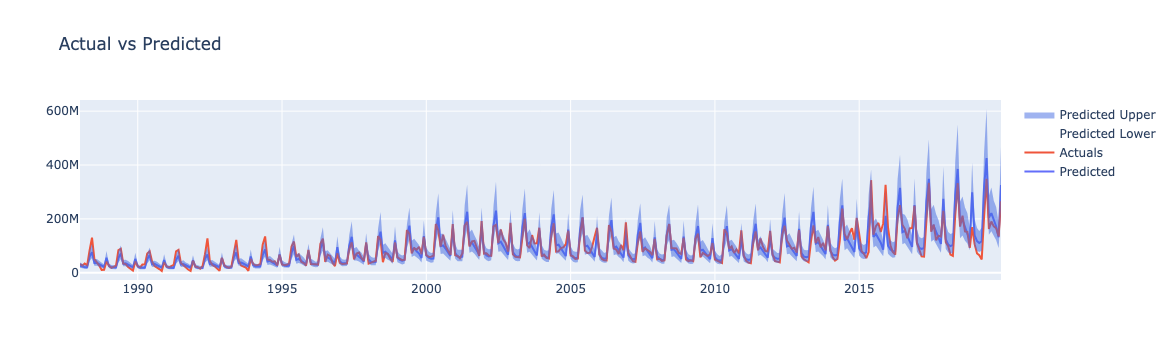

In [23]:
## plot predicted values against actuals, for test range (2018 and 2019 only)
fig = go.Figure()
x_vals1 = df_year_filter(model_eval_exp, 1988, 2019)['ds']


# fig = px.line(preds, title='prediction vs actual', )
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= model_eval_exp['y-predicted'], name = 'Predicted'
))
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= model_eval_exp['y-actual'], name = 'Actuals'
))

fig.update_layout(title='Actual vs Predicted')

fig.add_trace(go.Scatter(x=x_vals1, y=model_eval_exp['yhat_upper'],
    fill=None,
    mode='lines',
    line_color='royalblue',line_width=0, name='Predicted Lower'
    ))
fig.add_trace(go.Scatter(
    x=x_vals1, y=model_eval_exp['yhat_lower'],
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='royalblue', line_width=0, name='Predicted Upper'))

fig.show()

In [24]:
df_compare = model_eval_exp

## Model 2: Prophet Tuned with CV

In [25]:
# us data - not adjusted for inflation
us_data = pd.read_csv('data/data_clean.csv')
us_data = us_data[us_data['Country'].str.contains('United States')].reset_index(drop=True)

# sum sales by period 
us_data = us_data[['Period', 'Value']]
us_data = us_data.groupby('Period').sum().reset_index()
us_data = us_data.rename(columns= {'Period': 'ds', 'Value':'y'})
us_data

ds          y
0    1988-01-01   14515954
1    1988-02-01   12230446
2    1988-03-01   15530879
3    1988-04-01   12658205
4    1988-05-01   38072540
..          ...        ...
424  2023-05-01  192319380
425  2023-06-01  321985092
426  2023-07-01  176271374
427  2023-08-01  150469147
428  2023-09-01  118812846

[429 rows x 2 columns]

### Get Best Params

??? How to use same test train split for comparison?
Train = 1988 to 2017
Test = 2018, 2019

Attempt:
* Use full dataset to get the best params. 
* Re run model with best params, for test, and train seperately, to get seperate scores for easier comparisons

In [26]:
documentation = {}
documentation['description'] = 'Replicating Model Found with 10% test MAPE, Value adjusted for inflation, no log'

In [27]:
# Prophet suggested ranges

changepoint_range = [0.001, 0.101,0.201,0.301,0.401,0.5]

# print('changepoint_range:',changepoint_range)

seasonality_range=[0.01, 1.01, 3.01, 5.0, 7.01, 10]
# print('seasonality_range: ', seasonality_range)

# holidays_range =  np.arange(0.01, 10, 0.5) 
holidays_range=  [0.01, 1.01, 3.01, 5.0, 7.01, 10]
# print('holidays_range: ', holidays_range)

seasonanility_mode = ['additive', 'multiplicative']
yearly_seasonality = [True, False] 

In [28]:

param_grid = {  
    'changepoint_prior_scale': changepoint_range,
    'seasonality_prior_scale': seasonality_range,
    'seasonality_mode':seasonanility_mode, 
    'yearly_seasonality':  yearly_seasonality  
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# all_params
documentation['params_options']= param_grid
documentation

{'description': 'Replicating Model Found with 10% test MAPE, Value adjusted for inflation, no log',
 'params_options': {'changepoint_prior_scale': [0.001,
   0.101,
   0.201,
   0.301,
   0.401,
   0.5],
  'seasonality_prior_scale': [0.01, 1.01, 3.01, 5.0, 7.01, 10],
  'seasonality_mode': ['additive', 'multiplicative'],
  'yearly_seasonality': [True, False]}}

QUESTION: 
* run model for entire data or just training range set given CV?
* default code df_cv value at index 0 meaning? 
* for each loop df_p returns RMSE's for many time horizons how to get one value ?
    * reconclie df_p, vs df_cv meaning
    * take average of all RMSE's in the loop (over different horizons)

In [30]:
# # Find the best parameters
tuning_results = pd.DataFrame(all_params)

tuning_results['rmse'] = rmses
tuning_results['mapes'] = mapes
tuning_results['rmses_avg'] = rmses_avg
tuning_results['mapes_avg'] = mapes_avg
tuning_results.sort_values(by=[ 'mapes','rmse','rmses_avg', 'mapes_avg'], ascending = True)

NameError: name 'rmses' is not defined

In [43]:
## Best model params:
# Python
best_params = all_params[np.argmin(rmses)]

print(f'best params rmse score is {min(rmses)}')
best_params['rmse'] = min(rmses)

best_params['mape'] = min(mapes)

print(best_params)
documentation['best_params'] = best_params 

best params rmse score is 32588005.106221694
{'changepoint_prior_scale': 0.101, 'seasonality_prior_scale': 1.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'rmse': 32588005.106221694, 'mape': 0.19241111774265449}


### Get Predictions using best params

In [31]:
# set up dictionary to log all model details 
documentation = {}
# documentation['description'] = '???'
# create train data set for years 1988 to 2017, will predict years 2018,2019
train_start_year = 1988
train_end_year = 2017
train_data = df_year_filter(model_data_grouped, start_year=train_start_year, end_year=train_end_year)
train_data
documentation['train_data_source'] = 'model_data grouped, adjusted for inflation, no log'
documentation['train_start_year'] = train_start_year
documentation['train_end_year']= train_end_year

In [32]:
print(documentation)

{'train_data_source': 'model_data grouped, adjusted for inflation, no log', 'train_start_year': 1988, 'train_end_year': 2017}


In [33]:
test_start_year = 2018
test_end_year = 2019
test_data = df_year_filter(model_data_grouped, start_year=test_start_year, end_year=test_end_year)
test_data
documentation['test_data_source'] =  'model_data_grouped adjusted for inflation, no log'
documentation['test_start_year'] = test_start_year
documentation['test_end_year']= test_end_year

In [34]:
# initialise model,with best params

## variables 
cv_cutoffs = pd.to_datetime(['2018-01-01', '2019-01-01', ]) # manually set dates for new prediction
cv_initial = '10593 days' # number of days from 1988 to 2017
cv_period = '365 days'
cv_horizon = '365 days'
cv_parallel = 'processes'

m=Prophet(changepoint_prior_scale= best_params['changepoint_prior_scale']
          , seasonality_prior_scale=best_params['seasonality_prior_scale'],
          seasonality_mode= best_params['seasonality_mode'], yearly_seasonality= best_params['yearly_seasonality']).fit(model_data_grouped) 
# initial/train from 1988 to 2017 
# then after 2017, predict one year out every on Jan 1 2018, and Jan 1 2019
df_cv = cross_validation(m, initial=cv_initial, period=cv_period, horizon = cv_horizon, parallel=cv_parallel, cutoffs=cv_cutoffs)
print(df_cv)

now = datetime.now()
dt_string = now.strftime("%Y-%m-%d %H:%M")
documentation['model_params'] = best_params

documentation['model_fit_date'] = dt_string
documentation[".fit()"] =  get_variable_name(model_data_grouped, locals())
documentation['cv_param_cutoffs'] = cv_cutoffs
documentation['cv_param_initial'] = cv_initial
documentation['cv_param_period'] = cv_period
documentation['cv_param_horizon'] = cv_horizon
documentation['cv_param_parallel'] = cv_parallel

NameError: name 'best_params' is not defined

{'train_data_source': 'model_data grouped, adjusted for inflation, no log',
 'train_start_year': 1988,
 'train_end_year': 2017,
 'test_data_source': 'model_data_grouped adjusted for inflation, no log',
 'test_start_year': 2018,
 'test_end_year': 2019,
 'model_params': {'changepoint_prior_scale': 0.101,
  'seasonality_prior_scale': 1.01,
  'seasonality_mode': 'multiplicative',
  'yearly_seasonality': True,
  'rmse': 32588005.106221694,
  'mape': 0.19241111774265449},
 'model_fit_date': '2024-01-08 15:26',
 '.fit()': 'model_data_grouped',
 'cv_param_cutoffs': DatetimeIndex(['2018-01-01', '2019-01-01'], dtype='datetime64[ns]', freq=None),
 'cv_param_initial': '10593 days',
 'cv_param_period': '365 days',
 'cv_param_horizon': '365 days',
 'cv_param_parallel': 'processes',
 'model_prediction_date:': '2024-01-08 15:28',
 'Prediction range(num periods):': 24,
 'Prediction frequency:': 'MS',
 'results': {'Prophet-Best': {'mse_train': 442878256290016.7,
   'mse_test': 383085492245001.56,
   'rm

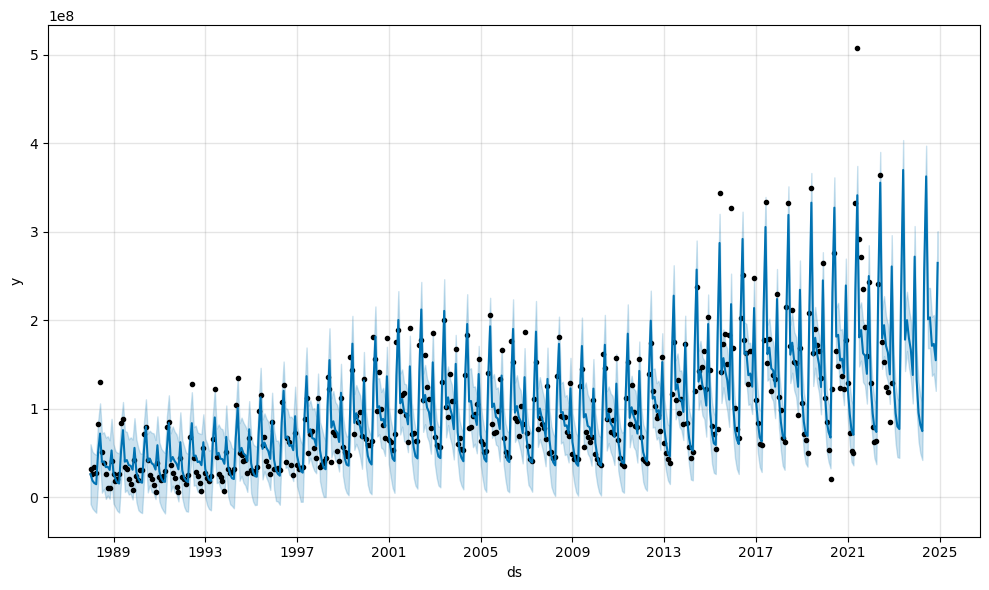

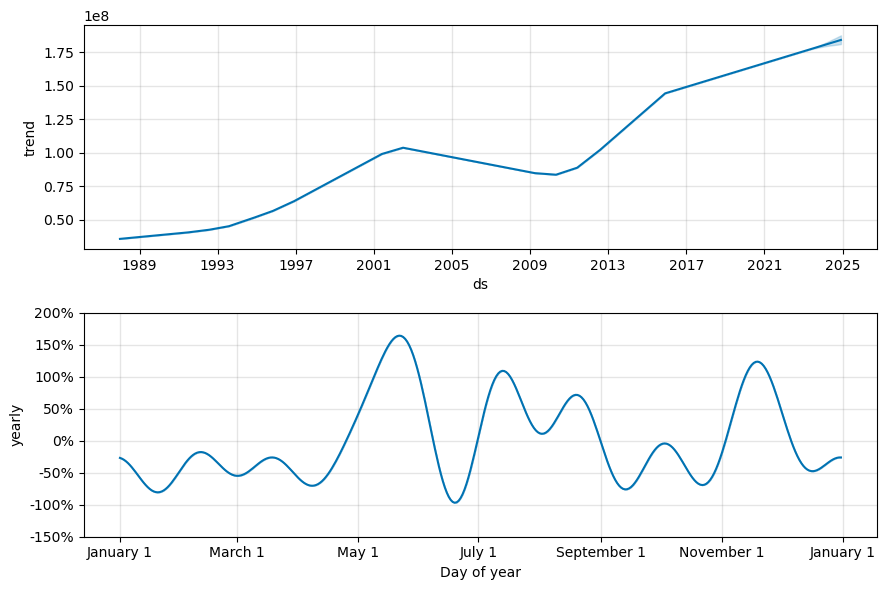

In [59]:
# predict 2018, 2019

prediction_range = 24
prediction_frequency = "MS"
future = m.make_future_dataframe(periods = prediction_range, freq=prediction_frequency)
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

# dd/mm/YY H:M:S
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d %H:%M")
documentation["model_prediction_date:"] =  dt_string
documentation["Prediction range(num periods):"] = prediction_range
documentation["Prediction frequency:"]= prediction_frequency
documentation

In [60]:
forecast = m.predict(future)
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predictions

ds           yhat     yhat_lower     yhat_upper
0   1988-01-01  26,267,933.51  -7,685,975.50  59,236,921.93
1   1988-02-01  18,906,940.57 -13,419,055.70  55,711,856.61
2   1988-03-01  16,200,579.38 -14,534,464.58  49,374,644.29
3   1988-04-01  14,849,507.04 -17,423,051.51  48,955,909.22
4   1988-05-01  50,970,289.36  19,048,060.64  84,097,535.12
..         ...            ...            ...            ...
439 2024-08-01 203,412,732.46 169,317,095.43 237,861,846.05
440 2024-09-01 171,223,977.54 138,332,200.73 206,025,974.95
441 2024-10-01 173,450,473.23 140,771,092.76 205,617,562.58
442 2024-11-01 154,933,309.65 123,080,436.10 188,668,522.88
443 2024-12-01 264,957,390.14 232,246,553.39 299,323,685.09

[444 rows x 4 columns]

#### Next steps:
* run on non log values
    * calc test / train metrics mannually
* run on noninflation adjusted vals
* Keep agg on months 

In [61]:
mape_idx = mapes.index(min(mapes))
print(mape_idx)
rmse_idx = rmses.index(min(rmses))
print(rmse_idx)

30
30


In [62]:
pd.DataFrame.from_dict(best_params, orient = 'index', columns = ['model_grouped_data'] )

model_grouped_data
changepoint_prior_scale               0.10
seasonality_prior_scale               1.01
seasonality_mode            multiplicative
yearly_seasonality                    True
rmse                         32,588,005.11
mape                                  0.19

In [63]:
documentation

{'train_data_source': 'model_data grouped, adjusted for inflation, no log',
 'train_start_year': 1988,
 'train_end_year': 2017,
 'test_data_source': 'model_data_grouped adjusted for inflation, no log',
 'test_start_year': 2018,
 'test_end_year': 2019,
 'model_params': {'changepoint_prior_scale': 0.101,
  'seasonality_prior_scale': 1.01,
  'seasonality_mode': 'multiplicative',
  'yearly_seasonality': True,
  'rmse': 32588005.106221694,
  'mape': 0.19241111774265449},
 'model_fit_date': '2024-01-08 15:26',
 '.fit()': 'model_data_grouped',
 'cv_param_cutoffs': DatetimeIndex(['2018-01-01', '2019-01-01'], dtype='datetime64[ns]', freq=None),
 'cv_param_initial': '10593 days',
 'cv_param_period': '365 days',
 'cv_param_horizon': '365 days',
 'cv_param_parallel': 'processes',
 'model_prediction_date:': '2024-01-08 15:28',
 'Prediction range(num periods):': 24,
 'Prediction frequency:': 'MS',
 'results': {'Prophet-Best': {'mse_train': 442878256290016.7,
   'mse_test': 383085492245001.56,
   'rm

In [64]:
# Model Eval Metrics
# split y actuals and predictions for train range
y_actual_train = df_year_filter(model_data_grouped, 1988, 2017)['y']
y_pred_train = df_year_filter(predictions, 1988, 2017)['yhat']

# RMSE - PROPHET - 1988 to 2017 TRAIN RANGE

mse_train = mean_squared_error(y_actual_train, y_pred_train, squared=True)
rmse_train =  mean_squared_error(y_actual_train, y_pred_train, squared=False)
mape_train = mean_absolute_percentage_error(y_actual_train, y_pred_train)
# print(f'Train Prophet MSE value is {mse_train: ,.2f}, years 1988 to 2017')
# print(f'Train Prophet RMSE value is {rmse_train : ,.2f}, years 1988 to 2017')
# print(f'Train Prophet MAPE value is {mape_train: ,.5f}, years 1988 to 2017')

# RMSE - PROPHET - 2018 to 2019 TEST RANGE
# split y actuals and predictions for TEST range
y_actual_test = df_year_filter(model_data_grouped, 2018, 2019)['y']
y_pred_test = df_year_filter(predictions, 2018, 2019)['yhat']


mse_test = mean_squared_error(y_actual_test, y_pred_test, squared=True)
rmse_test =  mean_squared_error(y_actual_test, y_pred_test, squared=False)
mape_test = mean_absolute_percentage_error(y_actual_test, y_pred_test)
# print(f'TEST Prophet MSE value is {mse_test: ,.2f}, years 2018 to 2019')
# print(f'TEST Prophet RMSE value is {rmse_test : ,.2f}, years 2018 to 2019')
# print(f'TEST Prophet MAPE value is {mape_test: ,.5f}, years 2018 to 2019')
best_prophet_vals = [mse_train, mse_test, rmse_train, rmse_test, mape_train, mape_test]

In [65]:
results = pd.DataFrame(data={'Prophet-Best':best_prophet_vals}, index = ['mse_train', 'mse_test', 'rmse_train', 'rmse_test', 'mape_train', 'mape_test'])

In [66]:
results

Prophet-Best
mse_train  442,878,256,290,016.69
mse_test   383,085,492,245,001.56
rmse_train          21,044,672.87
rmse_test           19,572,569.89
mape_train                   0.27
mape_test                    0.11

In [67]:
documentation['results'] = results.to_dict()

In [97]:
documentation

{'train_data_source': 'model_data grouped, adjusted for inflation, no log',
 'train_start_year': 1988,
 'train_end_year': 2022,
 'test_data_source': 'model_data_grouped adjusted for inflation, no log',
 'test_start_year': 2018,
 'test_end_year': 2019,
 'model_params': {'changepoint_prior_scale': 0.101,
  'seasonality_prior_scale': 1.01,
  'seasonality_mode': 'multiplicative',
  'yearly_seasonality': True,
  'rmse': 32588005.106221694,
  'mape': 0.19241111774265449},
 'model_fit_date': '2024-01-08 15:41',
 '.fit()': 'train_data',
 'cv_param_cutoffs': DatetimeIndex(['2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01'], dtype='datetime64[ns]', freq=None),
 'cv_param_initial': '10593 days',
 'cv_param_period': '365 days',
 'cv_param_horizon': '365 days',
 'cv_param_parallel': 'processes',
 'model_prediction_date:': '2024-01-08 15:41',
 'Prediction range(num periods):': 36,
 'Prediction frequency:': 'MS'}

## Make Predictions 

A ) Predict 2023 - 2025, feed in data up to 2022

In [71]:
# set up dictionary to log all model details 
documentation = {}
# documentation['description'] = '???'
# create train data set for years 1988 to 2017, will predict years 2018,2019
train_start_year = 1988
train_end_year = 2022
train_data = df_year_filter(model_data_grouped, start_year=train_start_year, end_year=train_end_year)
train_data
documentation['train_data_source'] = 'model_data grouped, adjusted for inflation, no log'
documentation['train_start_year'] = train_start_year
documentation['train_end_year']= train_end_year

In [72]:
print(documentation)

{'train_data_source': 'model_data grouped, adjusted for inflation, no log', 'train_start_year': 1988, 'train_end_year': 2022}


In [75]:
## Making predictions no test data
test_start_year = 'n/a'
test_end_year = 'n/a - making predictions'
# test_data = df_year_filter(model_data_grouped, start_year=test_start_year, end_year=test_end_year)
# test_data
documentation['test_data_source'] =  'none - making predictions using full data set'
documentation['test_start_year'] = test_start_year
documentation['test_end_year']= test_end_year

In [78]:
# initialise model,with best params

## variables 
cv_cutoffs = pd.to_datetime(['2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01',]) # manually set dates for new prediction
cv_initial = '10593 days' # number of days from 1988 to 2017
cv_period = '365 days'
cv_horizon = '365 days'
cv_parallel = 'processes'

m=Prophet(changepoint_prior_scale= best_params['changepoint_prior_scale']
          , seasonality_prior_scale=best_params['seasonality_prior_scale'],
          seasonality_mode= best_params['seasonality_mode'], yearly_seasonality= best_params['yearly_seasonality']).fit(train_data) 
# initial/train from 1988 to 2017 
# then after 2017, predict one year out every on Jan 1 2018, and Jan 1 2019
df_cv = cross_validation(m, initial=cv_initial, period=cv_period, horizon = cv_horizon, parallel=cv_parallel, cutoffs=cv_cutoffs)
print(df_cv)

now = datetime.now()
dt_string = now.strftime("%Y-%m-%d %H:%M")
documentation['model_params'] = best_params

documentation['model_fit_date'] = dt_string
documentation[".fit()"] =  get_variable_name(train_data, locals())
documentation['cv_param_cutoffs'] = cv_cutoffs
documentation['cv_param_initial'] = cv_initial
documentation['cv_param_period'] = cv_period
documentation['cv_param_horizon'] = cv_horizon
documentation['cv_param_parallel'] = cv_parallel

15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  97,796,434.14  72,878,887.39 125,618,315.50  98,741,054.26   
1  2018-03-01  85,078,276.00  59,946,706.71 112,020,446.94  67,438,386.00   
2  2018-04-01  85,223,547.84  59,609,753.93 110,074,187.50  62,713,512.57   
3  2018-05-01 235,902,602.27 210,527,946.87 260,539,068.97 214,656,623.05   
4  2018-06-01 334,628,777.71 309,633,304.19 361,395,008.90 332,987,171.41   
5  2018-07-01 168,733,932.96 145,253,927.23 195,574,552.35 171,257,481.32   
6  2018-08-01 188,765,109.15 164,179,679.06 213,940,260.28 211,866,990.47   
7  2018-09-01 171,239,285.92 145,865,224.31 196,868,709.82 153,366,691.92   
8  2018-10-01 165,644,063.77 141,438,758.27 190,694,102.73 151,565,834.70   
9  2018-11-01 149,564,252.93 125,199,625.40 173,565,386.73  92,707,416.91   
10 2018-12-01 292,518,611.43 266,709,184.68 318,370,779.20 169,260,055.54   
11 2019-01-01 132,629,218.48 105,189,158.11 159,182,475.86 106,274,121.40   

15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing


{'train_data_source': 'model_data grouped, adjusted for inflation, no log',
 'train_start_year': 1988,
 'train_end_year': 2022,
 'test_data_source': 'model_data_grouped adjusted for inflation, no log',
 'test_start_year': 2018,
 'test_end_year': 2019,
 'model_params': {'changepoint_prior_scale': 0.101,
  'seasonality_prior_scale': 1.01,
  'seasonality_mode': 'multiplicative',
  'yearly_seasonality': True,
  'rmse': 32588005.106221694,
  'mape': 0.19241111774265449},
 'model_fit_date': '2024-01-08 15:41',
 '.fit()': 'train_data',
 'cv_param_cutoffs': DatetimeIndex(['2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01'], dtype='datetime64[ns]', freq=None),
 'cv_param_initial': '10593 days',
 'cv_param_period': '365 days',
 'cv_param_horizon': '365 days',
 'cv_param_parallel': 'processes',
 'model_prediction_date:': '2024-01-08 15:41',
 'Prediction range(num periods):': 36,
 'Prediction frequency:': 'MS'}

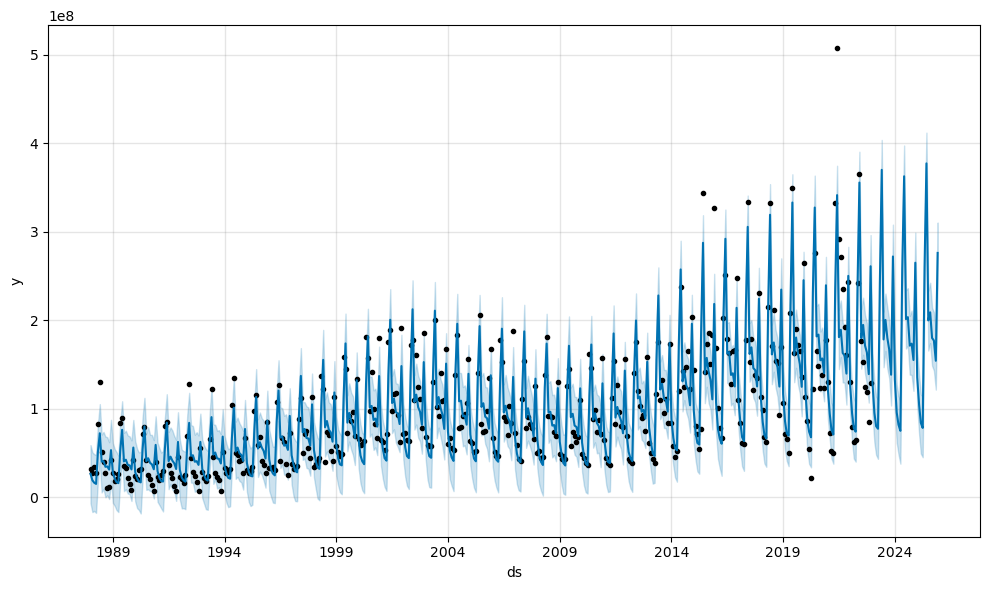

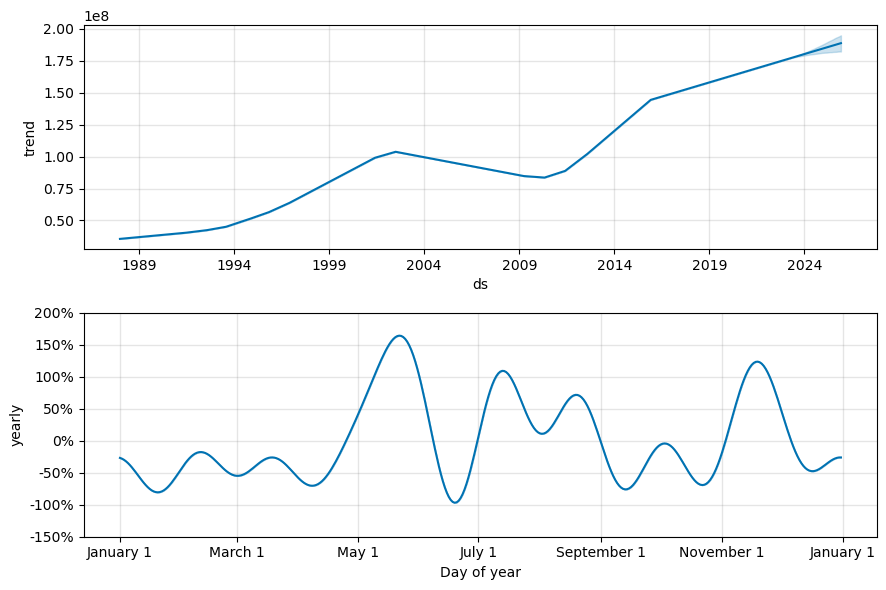

In [79]:
# predict 2023, 2024, 2025

prediction_range = 36
prediction_frequency = "MS"
future = m.make_future_dataframe(periods = prediction_range, freq=prediction_frequency)
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

# dd/mm/YY H:M:S
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d %H:%M")
documentation["model_prediction_date:"] =  dt_string
documentation["Prediction range(num periods):"] = prediction_range
documentation["Prediction frequency:"]= prediction_frequency
documentation

In [93]:
forecast = m.predict(future)
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predictions

ds           yhat     yhat_lower     yhat_upper
0   1988-01-01  26,267,933.51  -5,819,882.84  57,345,459.45
1   1988-02-01  18,906,940.57 -13,677,747.65  52,135,576.09
2   1988-03-01  16,200,579.38 -16,494,619.77  50,436,041.48
3   1988-04-01  14,849,507.04 -16,948,591.97  47,659,340.32
4   1988-05-01  50,970,289.36  16,805,621.21  85,276,435.71
..         ...            ...            ...            ...
451 2025-08-01 208,849,453.14 175,925,897.89 245,868,769.60
452 2025-09-01 179,817,328.93 145,688,365.80 213,472,336.03
453 2025-10-01 176,893,150.11 141,378,508.25 208,794,735.83
454 2025-11-01 154,078,299.96 119,158,343.46 189,070,277.82
455 2025-12-01 276,039,519.74 242,269,179.07 311,876,482.48

[456 rows x 4 columns]

## Visualise Results

In [94]:
# merge predictions and actuals into one DF:

predictions = predictions.merge(model_data_grouped, on='ds', how='outer')
predictions = predictions.rename(columns = {'yhat': 'Predicted', 'y':'Actual'})
predictions

ds      Predicted     yhat_lower     yhat_upper        Actual
0   1988-01-01  26,267,933.51  -5,819,882.84  57,345,459.45 32,094,345.55
1   1988-02-01  18,906,940.57 -13,677,747.65  52,135,576.09 26,852,319.99
2   1988-03-01  16,200,579.38 -16,494,619.77  50,436,041.48 34,003,540.09
3   1988-04-01  14,849,507.04 -16,948,591.97  47,659,340.32 27,637,080.92
4   1988-05-01  50,970,289.36  16,805,621.21  85,276,435.71 82,665,791.27
..         ...            ...            ...            ...           ...
451 2025-08-01 208,849,453.14 175,925,897.89 245,868,769.60           NaN
452 2025-09-01 179,817,328.93 145,688,365.80 213,472,336.03           NaN
453 2025-10-01 176,893,150.11 141,378,508.25 208,794,735.83           NaN
454 2025-11-01 154,078,299.96 119,158,343.46 189,070,277.82           NaN
455 2025-12-01 276,039,519.74 242,269,179.07 311,876,482.48           NaN

[456 rows x 5 columns]

In [96]:
# export predictions to use in tableau 
predictions.to_csv('data/predictions.csv', index=False)

In [6]:
## plot predicted values against actuals, for test range (2018 and 2019 only)
fig = go.Figure()
x_vals1 = predictions['ds']


# fig = px.line(preds, title='prediction vs actual', )
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= predictions['Predicted'], name = 'Predicted'
))
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= predictions['Actual'], name = 'Actuals'
))

fig.update_layout(title='Actual vs Predicted')

# fig.add_trace(go.Scatter(x=x_vals1, y=model_eval_exp['yhat_upper'],
#     fill=None,
#     mode='lines',
#     line_color='royalblue',line_width=0, name='Predicted Lower'
#     ))
# fig.add_trace(go.Scatter(
#     x=x_vals1, y=model_eval_exp['yhat_lower'],
#     fill='tonexty', # fill area between trace0 and trace1
#     mode='lines', line_color='royalblue', line_width=0, name='Predicted Upper'))


# fig.write_html("data/Actual_vs_Predicted.html")
fig.show()

NameError: name 'go' is not defined

NameError: name 'fig' is not defined

# Bin

In [82]:
tuning_attempts['smaller_CPS'] = best_params
tuning_attempts

attempt1   initial=10yrs   initial=15yrs  \
changepoint_prior_scale               5               5               5   
seasonality_prior_scale              25              25              25   
seasonality_mode         multiplicative  multiplicative  multiplicative   
yearly_seasonality                 True            True            True   
rmse                      84,155,734.63   84,155,734.63   84,155,734.63   

                            smaller_CPS  
changepoint_prior_scale               5  
seasonality_prior_scale           15.00  
seasonality_mode         multiplicative  
yearly_seasonality                 True  
rmse                      83,961,852.17

In [81]:
# attempt1_results = pd.DataFrame.from_dict(best_params, orient='index', columns = ['attempt1'])
tuning_attempts

attempt1   initial=10yrs   initial=15yrs
changepoint_prior_scale               5               5               5
seasonality_prior_scale              25              25              25
seasonality_mode         multiplicative  multiplicative  multiplicative
yearly_seasonality                 True            True            True
rmse                      84,155,734.63   84,155,734.63   84,155,734.63